# Biharmonic Equation

In this project, we will attempt to numerically resolve the biharmonic equation for Stokes flow in the case a square cavity, with a top lid moving at aconstant velocity, with no fluid leaking from within the cavity. To do so, we will use the conjugate gradient method.

In [ ]:
import numpy

In [2]:
nx = 41
ny = 41

l = 1.
h = 1.

dx = l/(nx-1)
dy = h/(ny-1)

l1_target = 1e-8

In [3]:
def L1norm(new, old):
    norm = numpy.sum(numpy.abs(new-old))
    return norm

## Discretization and boundary conditions

First,we discretize the biharmonic equation with a second order central finite difference discretization.Using a central finite discretization (found here https://en.wikipedia.org/wiki/Finite_difference_coefficient) we can express the biharmonic equation as:
\begin{equation}
\nabla^4 \psi= \frac{\psi_{i-2,j}-4\psi_{i-1,j}+6\psi_{i,j}-4\psi_{i+1,j}+\psi_{i+2,j}}{\Delta x^4}+\frac{\psi_{i,j-2}-4\psi_{i,j-1}+6\psi_{i,j}-4\psi_{i,j+1}+\psi_{i,j+2}}{\Delta y^4}+2\frac{\psi_{i-1,j-1}-2\psi_{i-1,j}+\psi_{i-1,j+1}-2\psi_{i,j-1}+4\psi_{i,j}-2\psi_{i,j+1}+\psi_{i+1,j-1}-2\psi_{i+1,j}+\psi_{i+1,j+1}}{\Delta x^2\Delta y^2}=0
\end{equation} where psi is the stream function

We must now implement a discretization for our Neumann boundary conditions. We used a second order foward finite discretization for the left and bottom boundaries, and backwards for the right and top boundaries. This gives us the following boundary conditions:

 
Left (x=0):    \begin{equation}
\psi_{0,j}=0
\end{equation}

\begin{equation}
\frac{\partial \psi}{\partial x}= \frac{\frac{-3}{2}\psi_{0,j}+2\psi_{1,j}-\frac{1}{2}\psi_{2,j}}{\Delta x}=0
\end{equation}

Right (x=l):     \begin{equation}
\psi_{l,j}=0
\end{equation}

\begin{equation}
\frac{\partial \psi}{\partial x}= \frac{\frac{1}{2}\psi_{l-2,j}-2\psi_{l-1,j}+\frac{3}{2}\psi_{l,j}}{\Delta x}=0
\end{equation}

Bottom (y=0):     \begin{equation}
\psi_{i,0}=0
\end{equation}

\begin{equation}
\frac{\partial \psi}{\partial y}= \frac{\frac{-3}{2}\psi_{i,0}+2\psi_{i,1}-\frac{1}{2}\psi_{i,2}}{\Delta y}=0
\end{equation}

Top (y=h):     \begin{equation}
\psi_{i,h}=0
\end{equation}

\begin{equation}
\frac{\partial \psi}{\partial y}= \frac{\frac{1}{2}\psi_{i,h-2}-2\psi_{i,h-1}+\frac{3}{2}\psi_{i,h}}{\Delta y}=1
\end{equation}
Our top boundary conditions are different, due to the presence of the moving lid.

## Conjugate gradient resolution
We will now define the BiharmonicSolution function that takes an initial guess of psi, the paramaters of the cavity, aswell as the precision we whish to achieve, and iterates the conjugate gradient method until the L1 norm between two iterated solutions would be lower than our target precision.

In [119]:
def BiharmonicSolution(psi0, dx, dy,l1_target):
    def A(psi):
        out=(psi[2:-2,0:-4]-4*psi[2:-2,1:-3]+6*psi[2:-2,2:-2]-4*psi[2:-2,3:-1]+psi[2:-2,4:])/(dx**4)+(psi[0:-4,2:-2]-4*psi[1:-3,2:-2]+6*psi[2:-2,2:-2]-4*psi[3:-1,2:-2]+psi[4:,2:-2])/(dy**4)+2*(psi[1:-3,1:-3]-2*psi[2:-2,1:-3]+psi[3:-1,1:-3]-2*psi[1:-3,2:-2]+4*psi[2:-2,2:-2]-2*psi[3:-1,2:-2]+psi[1:-3,3:-1]-2*psi[2:-2,3:-1]+psi[3:-1,3:-1])/(dx*dy)**2
        return out # A(psi) gives us our discretized biharmonic operator
    psi = psi0.copy()
    r = numpy.zeros_like(psi)
    Ad = numpy.zeros_like(psi)
    diff = l1_target + 1
    r[2:-2, 2:-2] =- A(psi)# we calculate our intial residual 
    d = r.copy() # this is our search direction
    ite=0       # this keeps track of our iterations
    while diff > l1_target:
        psik = psi.copy()
        rk = r.copy()
        Ad[2:-2, 2:-2] = A(d) # we apply the biharmonic operator to  d
        alpha = numpy.sum(r * r) / numpy.sum(d * Ad) # we compute the step size
        psi = psik + alpha * d # we update the solution
        r = rk - alpha * Ad    # we update the residual
        beta = numpy.sum(r * r) / numpy.sum(rk * rk) # we update the search direction
        d = r + beta * d
        #we will now apply our Neumann boundary conditions. The dirichlet conditions are automatically enforced
        psi[1:-1,1]=(1/4)*psi[1:-1,2]   #left boundary
        psi[1:-1,-2]=(1/4)*psi[1:-1,-3] #Right boundary
        psi[1,1:-1]=(1/4)*psi[2,1:-1]   #Bottom boundary
        psi[-2,1:-1]=(psi[-3,1:-1]-dy)/4#Top boundary
        diff = L1norm(psi, psik) #finally, we calculate the l1 norm between out iterations
        ite += 1

    return psi

We must now choose an intial guess for psi. Initially ,we took a matrix of zeroes, but it would have resulted in a division by zero when we computated the step size. We instead decided to appy our top boundary conditions to this zero-matrix:

In [128]:
psi0=numpy.zeros((nx,ny))
for i in range(1,40):
    psi0[-2 , i] = -dy/4
print(psi0)

[[ 0.       0.       0.      ...  0.       0.       0.     ]
 [ 0.       0.       0.      ...  0.       0.       0.     ]
 [ 0.       0.       0.      ...  0.       0.       0.     ]
 ...
 [ 0.       0.       0.      ...  0.       0.       0.     ]
 [ 0.      -0.00625 -0.00625 ... -0.00625 -0.00625  0.     ]
 [ 0.       0.       0.      ...  0.       0.       0.     ]]


In [121]:
BiharmonicSolution(psi0, dx, dy, l1_target) #Diff increases with the number of iterations but should be decreasing, related to incorect boundary conditions?

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  2.89705802e-08,  1.15882321e-07, ...,
         1.15882234e-07,  2.89705586e-08,  0.00000000e+00],
       [ 0.00000000e+00,  1.15882321e-07,  4.63529283e-07, ...,
         4.63528938e-07,  1.15882234e-07,  0.00000000e+00],
       ...,
       [ 0.00000000e+00, -9.82236754e-04, -3.92894702e-03, ...,
        -3.92894702e-03, -9.82236754e-04,  0.00000000e+00],
       [ 0.00000000e+00, -6.49555919e-03, -7.23223675e-03, ...,
        -7.23223675e-03, -6.49555919e-03,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

We will now plot our solution

In [129]:
import matplotlib

In [130]:
from matplotlib import pyplot

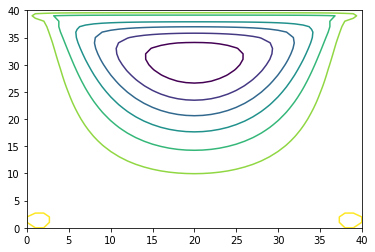

In [131]:
matplotlib.pyplot.contour(BiharmonicSolution(psi0, dx, dy, l1_target)) # plot is similar to expected, but flattened in y and stretched in x

We obtain a plot very similar to the one presented in the notebook lesson. We see that the closer we are to the center of the top boundary (while still being under it), the lower the the value of the stream function is. This implies that in this area our flux is constant. This may be due to the presence of a vortex in this area.

We will now determine the value of the stream function at specific coordinates:

In [127]:
psi=BiharmonicSolution(psi0, dx, dy, l1_target)
print('psi(0.6,0.2)=',psi[8,24])
print('psi(0.6,0.4)=',psi[16,24])
print('psi(0.6,0.6)=',psi[24,24])
print('psi(0.6,0.8)=',psi[32,24])

psi(0.6,0.2)= -0.002352048580824005
psi(0.6,0.4)= -0.009098110092892703
psi(0.6,0.6)= -0.019229969325212436
psi(0.6,0.8)= -0.025270733888399767
